## Isochrone Fitting for Quinn's Photometry

In [2]:
import numpy as np
import pandas as pd
import astropy.io.fits as pf
from astropy.table import Table
import matplotlib.pyplot as plt
import photutils as ph
import astropy.units as u
import astropy.constants as c
import glob
import os

In [33]:
# Adjust rc parameters to make plots pretty
def plot_pretty(dpi=200, fontsize=8):
    
    import matplotlib.pyplot as plt

    plt.rc("savefig", dpi=dpi)       # dpi resolution of saved image files
    # if you have LaTeX installed on your laptop, uncomment the line below for prettier labels
    plt.rc('text', usetex=True)      # use LaTeX to process labels
    plt.rc('font', size=fontsize)    # fontsize
    plt.rc('xtick', direction='in')  # make axes ticks point inward
    plt.rc('ytick', direction='in')
    plt.rc('xtick.major', pad=10) 
    plt.rc('xtick.minor', pad=5)
    plt.rc('ytick.major', pad=10) 
    plt.rc('ytick.minor', pad=5)
    plt.rc('lines', dotted_pattern = [0.5, 1.1]) # fix dotted lines
    plt.rc('font',family='computer modern')

    return

plot_pretty()

In [34]:
# read in quinn's photometry

photomet = glob.glob('/Users/f006zcq/Desktop/Dartmouth/SP25/A118/A118-Assign3/data/photometry/*.csv')


In [35]:
photom = {}
photom_err = {}
for i,file in enumerate(photomet):
    if 'err' in file:
        dwarf = os.path.splitext(os.path.basename(file))[0][:-4]
        photom_err[dwarf] = pd.read_csv(file)
    else:
        dwarf = os.path.splitext(os.path.basename(file))[0][:-5]
        photom[dwarf] = pd.read_csv(file)

In [36]:
def read_dsep(filename, dm):

    dsep_txt = np.genfromtxt(filename, dtype=float, comments='#', unpack=True)
    dsep_g = dsep_txt[10]
    dsep_r = dsep_txt[15]

    dsep = pd.DataFrame({'g':dsep_g, 'r':dsep_r})
    dsep['gr'] = dsep['g'] - dsep['r']
    dsep['y'] = dsep['r'] + dm

    return dsep

In [37]:
5*np.log10(0.1e6) - 5

20.0

In [38]:
isochrones = {}

isos = glob.glob('/Users/f006zcq/Desktop/Dartmouth/SP25/A118/A118-Assign3/data/isochrones/DSEP/10-12Gyr/*.iso')

for i,iso in enumerate(isos):
    file = os.path.splitext(os.path.basename(iso))[0]
    for dmod in np.linspace(17,21,30):
        dseps = read_dsep(iso,dmod)
        isochrones[file+str(dmod)]=dseps

In [39]:
isochrones.keys()

dict_keys(['10Gyr-2417.0', '10Gyr-2417.137931034482758', '10Gyr-2417.275862068965516', '10Gyr-2417.413793103448278', '10Gyr-2417.551724137931036', '10Gyr-2417.689655172413794', '10Gyr-2417.82758620689655', '10Gyr-2417.96551724137931', '10Gyr-2418.103448275862068', '10Gyr-2418.24137931034483', '10Gyr-2418.379310344827587', '10Gyr-2418.517241379310345', '10Gyr-2418.655172413793103', '10Gyr-2418.79310344827586', '10Gyr-2418.93103448275862', '10Gyr-2419.06896551724138', '10Gyr-2419.20689655172414', '10Gyr-2419.344827586206897', '10Gyr-2419.482758620689655', '10Gyr-2419.620689655172413', '10Gyr-2419.758620689655174', '10Gyr-2419.896551724137932', '10Gyr-2420.03448275862069', '10Gyr-2420.17241379310345', '10Gyr-2420.310344827586206', '10Gyr-2420.448275862068964', '10Gyr-2420.586206896551722', '10Gyr-2420.724137931034484', '10Gyr-2420.862068965517242', '10Gyr-2421.0', '12Gyr-217.0', '12Gyr-217.137931034482758', '12Gyr-217.275862068965516', '12Gyr-217.413793103448278', '12Gyr-217.5517241379310

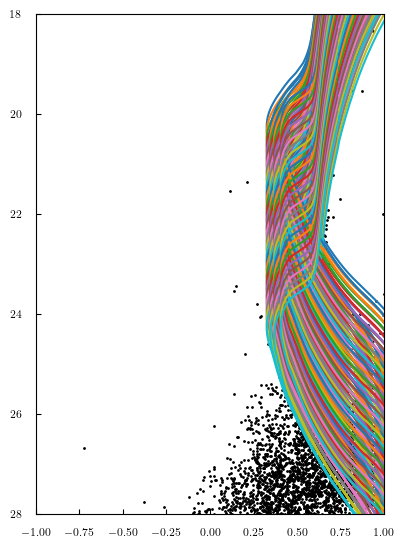

In [40]:
plt.figure(figsize=(4.5,6.5))

for iso in isochrones.keys():
    plt.plot(isochrones[iso]['gr'],isochrones[iso]['y'],label=iso)


plt.scatter(photom['leo']['color'],photom['leo']['f814w'],1,color='k')

plt.xlim(-1,1)
plt.ylim(18,28)
plt.gca().invert_yaxis()


In [11]:
from scipy.spatial import cKDTree

def chi2_match(obs_data, isochrone, ufd, mag_err=0.05, color_err=0.05):
    """
    compute the chi^2 between observed stars and an isochrone.
    For each observed star, finds the closest point on the isochrone in CMD space.
    """
    # use a KDTree for distances
    tree = cKDTree(isochrone[['gr', 'y']].values)

    # find nearest isochrone point
    # make sure to remove nans and infs
    if ufd == 'coma_berenices':

        quality_cut = (obs_data['f814w'] < 22.5) & (obs_data['f814w']>14) 
        quality_cut &= (obs_data['color']>0.25) 
        quality_cut &= (obs_data['color']<1)
    elif ufd == 'leo' or ufd == 'canes_venatici':

        quality_cut = (obs_data['f814w'] < 24.5) & (obs_data['f814w']>14)
        quality_cut &= (obs_data['color']>0.25) 
        quality_cut &= (obs_data['color']<1)
    elif ufd == 'ursa_major':
        
        quality_cut = (obs_data['color'] < 0.68) & (obs_data['color'] > 0.2) & (obs_data['f814w']>20) & (obs_data['f814w']<24)
        #quality_cut &= (obs_data['color']>0.25) 
        #quality_cut &= (obs_data['color']<1)
    elif ufd == 'bootes':

        quality_cut = (obs_data['f814w'] < 24) & (obs_data['f814w']>19)
        quality_cut &= (obs_data['color']>0.4) 
        quality_cut &= (obs_data['color']<0.75)
    elif ufd == 'hercules':

        quality_cut = (obs_data['f814w'] < 26) & (obs_data['f814w']>20)
        quality_cut &= (obs_data['color']>0.25) 
        quality_cut &= (obs_data['color']<0.75)
            
    dists, idxs = tree.query(obs_data[quality_cut][['color', 'f814w']].dropna())

    # compute chi^2
    chi2 = np.sum((dists ** 2) / (mag_err**2 + color_err**2))

    # get reduced chi^2
    # calculate degrees of freedom following https://www.aanda.org/articles/aa/pdf/2021/05/aa40413-21.pdf
    # r = 2 since we're using 2 bands
    # n = # of observed stars
    # p = 2 # of hyperparemeters we're changing (metallicity and age)
    r = 2
    n = len(obs_data)
    p = 2
    dof = (r-1)*(n-p)
    return chi2/dof

def find_best_isochrone(obs_data, isochrones, mag_err, color_err,ufd):
    """
    Return best fit isochrone
    """
    chi2_values = []

    for i, iso in enumerate(isochrones.keys()):
        chi2 = chi2_match(obs_data, isochrones[iso], ufd, mag_err, color_err)
        chi2_values.append(chi2)

    best_index = np.argmin(chi2_values)
    return best_index, chi2_values[best_index]

In [12]:
find_best_isochrone(photom['leo'],isochrones,ufd = 'leo',mag_err=0,color_err=np.mean(photom_err['leo']))

(239, 1.6001849002647893e-05)

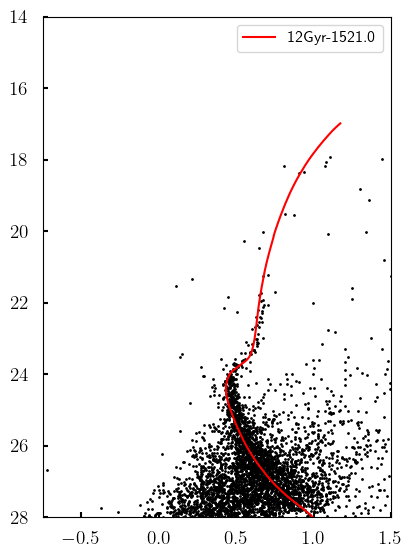

In [13]:
plt.figure(figsize=(4.5,6.5))
iso = list(isochrones.keys())
plt.plot(isochrones[iso[89]]['gr'],isochrones[iso[89]]['y'],label=iso[89],color='r')


plt.scatter(photom['leo']['color'],photom['leo']['f814w'],1,color='k')
plt.legend(fontsize='x-large')
plt.xlim(-0.75,1.5)
plt.ylim(14,28)
plt.tick_params(axis='y',labelsize='xx-large',width='1.5',
                color='k')
plt.tick_params(axis='x',labelsize='xx-large',width='1.5',
                color='k')
plt.gca().invert_yaxis()

RESULTS FOR: coma_berenices
best fit isochrone: 214 12gyr-12517.551724137931036
reduced chi^2 3.738392300131654e-05
RESULTS FOR: leo
best fit isochrone: 239 12gyr-12521.0
reduced chi^2 1.6001849002647893e-05
RESULTS FOR: canes_venatici
best fit isochrone: 236 12gyr-12520.586206896551722
reduced chi^2 1.1573308993574919e-05
RESULTS FOR: ursa_major
best fit isochrone: 229 12gyr-12519.620689655172413
reduced chi^2 7.633706900172277e-06
RESULTS FOR: bootes
best fit isochrone: 74 12Gyr-1518.93103448275862
reduced chi^2 1.8480740490259007e-05
RESULTS FOR: hercules
best fit isochrone: 87 12Gyr-1520.724137931034484
reduced chi^2 9.462051014031385e-05


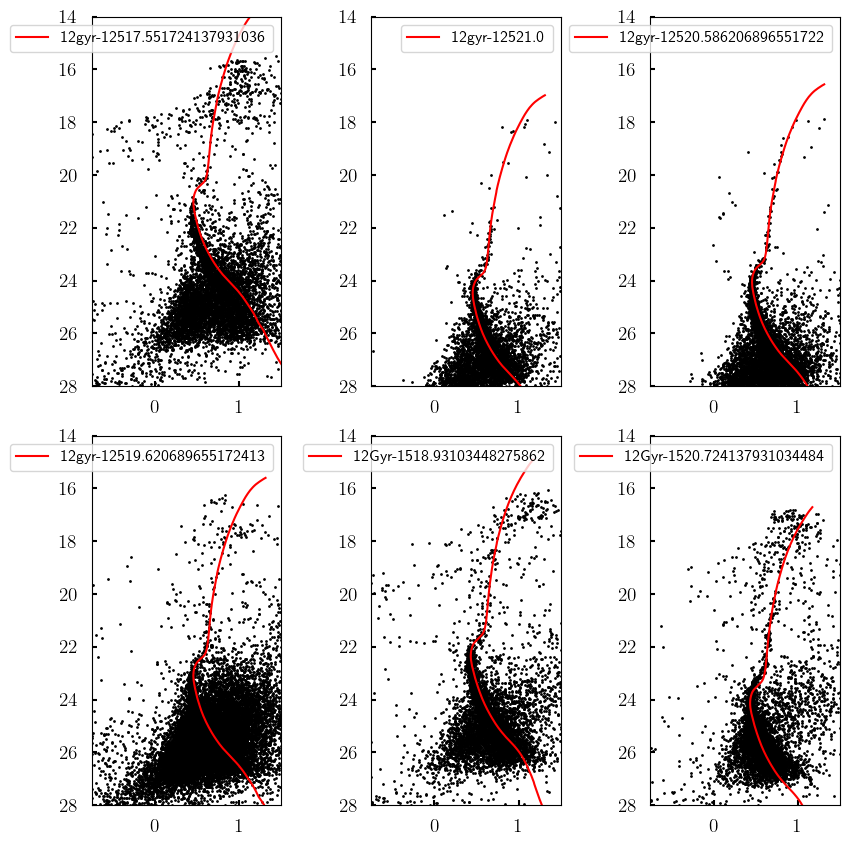

In [14]:
UFDS = list(photom.keys())
fig, axs = plt.subplots(nrows=2,ncols=3,figsize=(8.5,8.5))
axs = axs.ravel()
iso_fit = []
chi_fit = []
for i,ufd in enumerate(UFDS):
    idx, chi2 =  find_best_isochrone(photom[ufd],isochrones,ufd=ufd,mag_err=0,color_err=np.mean(photom_err[ufd]))
    iso = list(isochrones.keys())
    print('================================')
    print('RESULTS FOR:',ufd)
    print('best fit isochrone:',idx,iso[idx])
    print('reduced chi^2',chi2)
    print('================================')

    iso_fit.append(idx)
    chi_fit.append(chi2)
    axs[i].plot(isochrones[iso[idx]]['gr'],isochrones[iso[idx]]['y'],label=iso[idx],color='r')


    axs[i].scatter(photom[ufd]['color'],photom[ufd]['f814w'],1,color='k')
    axs[i].legend(fontsize='x-large')
    axs[i].set_xlim(-0.75,1.5)
    axs[i].set_ylim(14,28)
    axs[i].tick_params(axis='y',labelsize='xx-large',width='1.5',
                    color='k')
    axs[i].tick_params(axis='x',labelsize='xx-large',width='1.5',
                    color='k')
    axs[i].invert_yaxis()

plt.tight_layout()
plt.show()

In [15]:
list(photom.keys())

['coma_berenices', 'leo', 'canes_venatici', 'ursa_major', 'bootes', 'hercules']

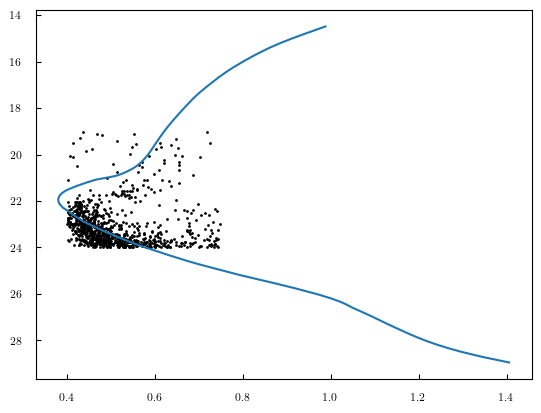

In [16]:
obs_data = photom['bootes']
quality_cut = (obs_data['f814w'] < 24) & (obs_data['f814w']>19)
quality_cut &= (obs_data['color']>0.4) 
quality_cut &= (obs_data['color']<0.75)
isos = list(isochrones.keys())
plt.scatter(obs_data[quality_cut]['color'],obs_data[quality_cut]['f814w'],1,color='k')

plt.plot(isochrones[isos[40]]['gr'],isochrones[isos[40]]['y'])

#plt.xlim(-0.75,1.5)
#plt.ylim(14,28)
plt.gca().invert_yaxis()

In [17]:
for i in iso_fit:
    print(isos[i])

12gyr-12517.551724137931036
12gyr-12521.0
12gyr-12520.586206896551722
12gyr-12519.620689655172413
12Gyr-1518.93103448275862
12Gyr-1520.724137931034484


In [18]:
brown_data = {}
files_cat = glob.glob('/Users/f006zcq/Desktop/Dartmouth/SP25/A118/A118-Assign3/data/*cat.fits')
UFDS_FILEFMT = ['comaberenices','leoiv','canesvenaticiii','ursamajori','bootesi','hercules']
for file in files_cat:
    cat = pf.open(file)[1].data
    for ufd in UFDS_FILEFMT:
        if ufd in file:
            brown_data[ufd]=cat


In [19]:
brown_data

{'comaberenices': FITS_rec([([186.88094919, 186.87833926, 186.88445628, ..., 186.62489501, 186.60832325, 186.61193228], [23.88839841, 23.88522757, 23.89361216, ..., 23.94426633, 23.92202308, 23.92710089], [29.607, 28.494, 27.392, ..., 25.014, 24.426, 27.183], [0.303, 0.097, 0.084, ..., 0.03 , 0.029, 0.054], [28.326, 27.81 , 27.895, ..., 24.927, 24.81 , 27.231], [0.19 , 0.097, 0.12 , ..., 0.031, 0.023, 0.082])],
          dtype=(numpy.record, [('RA', '>f8', (7825,)), ('DEC', '>f8', (7825,)), ('M606', '>f8', (7825,)), ('M606ERR', '>f8', (7825,)), ('M814', '>f8', (7825,)), ('M814ERR', '>f8', (7825,))])),
 'canesvenaticiii': FITS_rec([([194.33223642, 194.32798684, 194.32025717, ..., 194.2551236 , 194.25820472, 194.24677696], [34.30889286, 34.3073498 , 34.30319762, ..., 34.33637231, 34.33846596, 34.33215051], [31.01 , 29.23 , 29.335, ..., 29.467, 25.301, 29.738], [0.407, 0.1  , 0.103, ..., 0.106, 0.016, 0.102], [29.98 , 29.417, 29.926, ..., 29.675, 25.864, 28.691], [0.147, 0.069, 0.161, ...

RESULTS FOR: coma_berenices
best fit isochrone: 12 Gyr, [Fe/H] = -1.25
reduced chi^2 3.738392300131654e-05
distances (kpc) 32.38506906580733
RESULTS FOR: leo
best fit isochrone: 12 Gyr, [Fe/H] = -1.25
reduced chi^2 1.6001849002647893e-05
distances (kpc) 158.48931924611142
RESULTS FOR: canes_venatici
best fit isochrone: 12 Gyr, [Fe/H] = -1.25
reduced chi^2 1.1573308993574919e-05
distances (kpc) 130.99097638483818
RESULTS FOR: ursa_major
best fit isochrone: 12 Gyr, [Fe/H] = -1.25
reduced chi^2 7.633706900172277e-06
distances (kpc) 83.9726639627067
RESULTS FOR: bootes
best fit isochrone: 12 Gyr, [Fe/H]=-1.5
reduced chi^2 1.8480740490259007e-05
distances (kpc) 61.123314514084896
RESULTS FOR: hercules
best fit isochrone: 12 Gyr, [Fe/H]=-1.5
reduced chi^2 9.462051014031385e-05
distances (kpc) 139.5814116429633


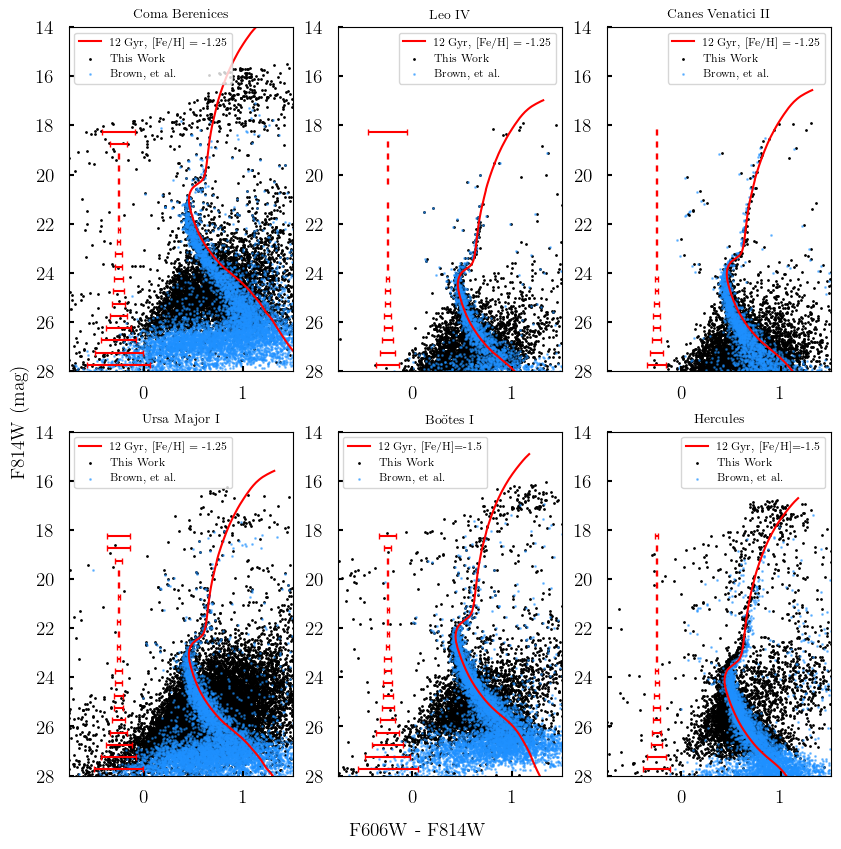

In [41]:

UFDS = list(photom.keys())
UFD_LABELS = ['Coma Berenices', 'Leo IV', 'Canes Venatici II','Ursa Major I','Boötes I', 'Hercules']
labels = ['12 Gyr, [Fe/H] = -1.25','12 Gyr, [Fe/H] = -1.25', '12 Gyr, [Fe/H] = -1.25',
          '12 Gyr, [Fe/H] = -1.25', '12 Gyr, [Fe/H]=-1.5','12 Gyr, [Fe/H]=-1.5']
dms = [17.551724137931036, 21.0, 20.586206896551722, 19.620689655172413, 18.93103448275862, 20.724137931034484 ]




fig, axs = plt.subplots(nrows=2,ncols=3,figsize=(8.5,8.5))
axs = axs.ravel()
iso_fit = []
chi_fit = []

for i,ufd in enumerate(UFDS):
    idx, chi2 =  find_best_isochrone(photom[ufd],isochrones,ufd=ufd,mag_err=0,color_err=np.mean(photom_err[ufd]))
    iso = list(isochrones.keys())
    print('================================')
    print('RESULTS FOR:',ufd)
    print('best fit isochrone:',labels[i])
    print('reduced chi^2',chi2)
    print('distances (kpc)',np.power(10,(5+dms[i])/5)/1000)


    iso_fit.append(idx)
    chi_fit.append(chi2)
    axs[i].plot(isochrones[iso[idx]]['gr'],isochrones[iso[idx]]['y'],label=labels[i],color='r')

    axs[i].set_title(UFD_LABELS[i])
    axs[i].scatter(photom[ufd]['color'],photom[ufd]['f814w'],1,color='k',label='This Work')

    brown_name = UFDS_FILEFMT[i]
    brown_col = (brown_data[brown_name]['M606']-0.264) - (brown_data[brown_name]['M814']-1.264)
    brown_mag = brown_data[brown_name]['M814']-1.264

    axs[i].scatter(brown_col,brown_mag,1,color='dodgerblue',alpha=0.5,label='Brown, et al.')
    axs[i].errorbar(x=np.full(len(photom_err[ufd]),-0.25),y=photom_err[ufd]['bin'],xerr=photom_err[ufd]['color_err'],color='r',fmt=',',
                    capsize=2)
    axs[i].legend(fontsize='medium')
    axs[i].set_xlim(-0.75,1.5)
    axs[i].set_ylim(14,28)
    axs[i].tick_params(axis='y',labelsize='xx-large',width='1.5',
                    color='k')
    axs[i].tick_params(axis='x',labelsize='xx-large',width='1.5',
                    color='k')
    axs[i].invert_yaxis()

fig.supxlabel('F606W - F814W',fontsize='xx-large')
fig.supylabel('F814W (mag)',fontsize='xx-large')
plt.tight_layout()
plt.savefig('cmds.png',dpi=600)
plt.show()





In [21]:
photom_err[ufd]

,bin,f606w_err,f814w_err,color_err
0,18.25,0.001000,0.009833,0.010180
1,18.75,0.001000,0.001000,0.001414
2,19.25,0.001000,0.001000,0.001414
3,19.75,0.001000,0.001000,0.001414
4,20.25,0.001241,0.001000,0.001613
5,20.75,0.001963,0.001074,0.002300
6,21.25,0.002756,0.002122,0.003623
7,21.75,0.002828,0.002103,0.003601
8,22.25,0.004606,0.002758,0.005566
9,22.75,0.006206,0.003889,0.007606


In [22]:
brown_data[brown_name]

FITS_rec([([247.83168893, 247.83103105, 247.83046887, ..., 247.77075836, 247.77179821, 247.77082975], [12.79091367, 12.78975729, 12.78738696, ..., 12.79661679, 12.8019645 , 12.79880771], [29.613, 22.755, 29.578, ..., 30.049, 29.488, 29.381], [0.141, 0.002, 0.127, ..., 0.242, 0.178, 0.175], [30.309, 21.906, 29.14 , ..., 29.705, 30.907, 30.747], [0.29 , 0.001, 0.116, ..., 0.18 , 0.529, 0.378])],
         dtype=(numpy.record, [('RA', '>f8', (5240,)), ('DEC', '>f8', (5240,)), ('M606', '>f8', (5240,)), ('M606ERR', '>f8', (5240,)), ('M814', '>f8', (5240,)), ('M814ERR', '>f8', (5240,))]))

photom